## Generative adversarial networks
### Generating of MNIST digits with a GAN

Setting up

In [26]:
!pip3 install tqdm
!pip3 install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchsummary import summary
from torch.autograd.variable import Variable
from torch.utils.data import DataLoader
from torch.autograd import grad as torch_grad
import torchvision.transforms as transforms
from IPython import display
import matplotlib.pylab as plt
import ipywidgets

Check that we're running on GPU, and initialize our device

In [28]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    print("The code will run on GPU for MacOS devices with Metal programming framework.")
    device = torch.device('mps')
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
    device = torch.device('cpu')

The code will run on GPU.


Setup our MNIST dataloaders

In [29]:
batch_size = 64               # Batch size
nz = 100                      # Size of the input noise vector
ngf = 64                      # Scale number of conv filters in generator
ndf = 64                      # Scale number of conv filters in discriminator
nc = 3                        # Number of channels in the output image (RGB or black and white ecc)
model_input_size = 32         # Used to determine which model to use, options: (28, 32)
datasetName = "CIFAR10"       # Either MNIST, FashionMNIST or CIFAR10
useLSGAN = False              # If enabled uses least squared criterion instead of binary cross entropy (only if useWGAN=False)
useWGAN = True                # If true make the GAN a WGAN
weights_clip_value = 0.01     # When using WGAN clip weights of discriminator in range (-clip, +clip)

In [30]:
# MNIST dataset
if datasetName == "MNIST":
  trainset = datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([
                           transforms.Resize(28),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,)),
                       ]))
  train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
  testset = datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
                           transforms.Resize(28),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,)),
                       ]))
  test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
elif datasetName == "FashionMNIST":
  trainset = datasets.FashionMNIST('./data', train=True, download=True, transform=transforms.Compose([
                           transforms.Resize(28),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,)),
                       ]))
  train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
  testset = datasets.FashionMNIST('./data', train=False, download=True, transform=transforms.Compose([
                           transforms.Resize(28),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,)),
                       ]))
  test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
elif datasetName == "CIFAR10":
  trainset = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.Compose([
                           transforms.Resize(32),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,)),
                       ]))
  train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
  testset = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.Compose([
                           transforms.Resize(32),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,)),
                       ]))
  test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# Fashion MNIST dataset
"""

"""

Files already downloaded and verified
Files already downloaded and verified


'\n\n'

In [31]:
# SIZE TESTS
# ========================
a = nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False)
b = nn.ConvTranspose2d(ngf * 8, ngf * 4, 3, 2, 1, bias=False)
c = nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False)
n = torch.rand(100, 1, 1)
c(b(a(n))).shape

torch.Size([128, 14, 14])

## DCGAN

Implement **generator** network.

In [32]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [33]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super(Generator, self).__init__()
        self.input_size = input_size

        """
        self.fullyconnected = nn.Sequential(
            nn.Linear(nz, 1024),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(num_features=1024),
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(num_features=1024),
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(num_features=1024),
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.1),
            nn.Linear(1024, model_input_size * model_input_size),
            nn.Tanh(),
        )
        """
        
        self.dcmodel = 0
        if (model_input_size == 28):
          self.dcmodel = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(    ngf,      nc, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
          )
        elif (model_input_size == 32):
          self.dcmodel = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
          )

    def forward(self, x):
        # FEEDFOREWARD MODEL
        #x = x.view(x.size(0), -1)
        #x = self.fullyconnected(x)
        #x = x.view(x.size(0), 1, 28, 28)

        # CONVOLUTIONAL MODEL
        x = self.dcmodel(x)
        return x

Implement **discriminator** network.

In [34]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        """
        self.fulluconnected = nn.Sequential(
            nn.Linear(model_input_size * model_input_size, 1024),
            nn.Dropout(p=0.3),
            nn.LeakyReLU(0.1),
            #nn.BatchNorm1d(num_features=1024)
            nn.Linear(1024, 512),
            nn.Dropout(p=0.3),
            nn.LeakyReLU(0.1),
            #nn.BatchNorm1d(num_features=512),
            nn.Linear(512, 256),
            nn.Dropout(p=0.3),
            nn.LeakyReLU(0.1),
            #nn.BatchNorm1d(num_features=256),
            nn.Linear(256, 1),
        )
        """

        self.dcmodel = 0
        if (model_input_size == 28):
          self.dcmodel = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, 1, 3, 1, 0, bias=False),
          )
        elif (model_input_size == 32):
          self.dcmodel = nn.Sequential(
            # state size. (nc) x 32 x 32
            nn.Conv2d(nc, ndf * 2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # FEEDFOREWARD MODEL
        #x = x.view(x.size(0), -1)
        #x = self.fulluconnected(x)

        # CONVOLUTIONAL MODEL
        x = self.dcmodel(x)
        if (not useWGAN and not useLSGAN):
          x = torch.sigmoid(x)
        x = x.view(x.size(0), 1)        
        return x

In [35]:
def gradient_penalty(d, real_data, generated_data):
    use_cuda = True
    gp_weight = 10
    batch_size = real_data.size()[0]

    # Calculate interpolation
    alpha = torch.rand(batch_size, 1, 1, 1)
    alpha = alpha.expand_as(real_data)
    if use_cuda:
      alpha = alpha.cuda()
    interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
    interpolated = Variable(interpolated, requires_grad=True)
    if use_cuda:
      interpolated = interpolated.cuda()

    # Calculate probability of interpolated examples
    prob_interpolated = d(interpolated)

    # Calculate gradients of probabilities with respect to examples
    gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).cuda() if use_cuda else torch.ones(
                               prob_interpolated.size()),
                               create_graph=True, retain_graph=True)[0]

    # Gradients have shape (batch_size, num_channels, img_width, img_height),
    # so flatten to easily take norm per example in batch
    gradients = gradients.view(batch_size, -1)

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    # Return gradient penalty
    return gp_weight * ((gradients_norm - 1) ** 2).mean()

Utility functions that are handy

In [36]:


def make_ones(size):
    data = Variable(torch.ones(size, 1))
    return data.to(device)

def make_filled(size, value):
    data = Variable(torch.full(size, value))
    return data.to(device)

def make_zeros(size):
    data = Variable(torch.zeros(size, 1))
    return data.to(device)

#def make_noise(batch_size, size):
#    return torch.randn(batch_size, size).to(device)

def make_noise(batch_size, size):
    return torch.randn(batch_size, size, 1, 1).to(device)
    

Create generator and discriminator 

In [37]:
d = Discriminator().to(device)
d.apply(weights_init)
summary(d, (nc, model_input_size, model_input_size))
g = Generator(nz).to(device)
g.apply(weights_init)
summary(g, (nz, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 16, 16]           6,144
         LeakyReLU-2          [-1, 128, 16, 16]               0
            Conv2d-3            [-1, 256, 8, 8]         524,288
       BatchNorm2d-4            [-1, 256, 8, 8]             512
         LeakyReLU-5            [-1, 256, 8, 8]               0
            Conv2d-6            [-1, 512, 4, 4]       2,097,152
       BatchNorm2d-7            [-1, 512, 4, 4]           1,024
         LeakyReLU-8            [-1, 512, 4, 4]               0
            Conv2d-9              [-1, 1, 1, 1]           8,192
          Sigmoid-10              [-1, 1, 1, 1]               0
Total params: 2,637,312
Trainable params: 2,637,312
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.06
Params size (MB): 10.06
Estima

Train model

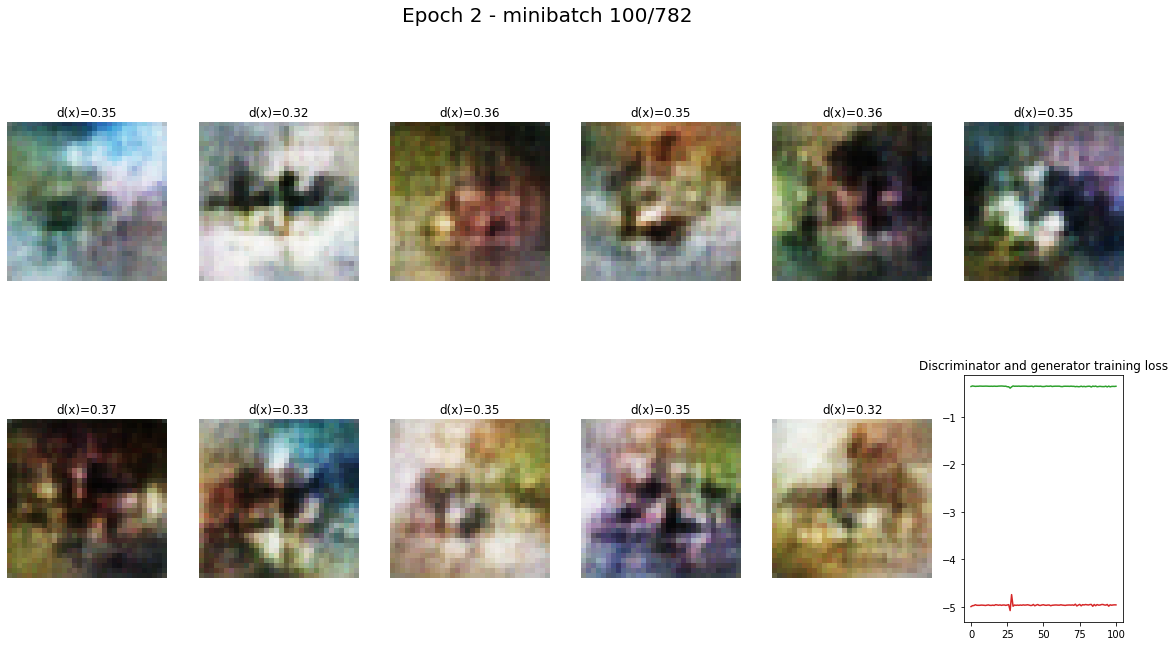

Epoch 1: g_loss: -0.36003807 d_loss: -1.00368976


In [ ]:
# Create optimizer
if (useWGAN):
  d_opt = torch.optim.RMSprop(d.parameters(), lr=0.00005)
  g_opt = torch.optim.RMSprop(g.parameters(), lr=0.00005)
else:
  d_opt = torch.optim.Adam(d.parameters(), lr=0.0001, betas=(0.5, 0.999))
  g_opt = torch.optim.Adam(g.parameters(),  lr=0.0001, betas=(0.5, 0.999))

# Choose loss function
if (useLSGAN):
  d_loss_fun = nn.MSELoss()
else:
  d_loss_fun = nn.BCELoss()

# Setup training
plt.figure(figsize=(20,10))
subplots = [plt.subplot(2, 6, k+1) for k in range(12)]
num_epochs = 10
if (useWGAN):
  iterations_discriminator = 5
else:
  iterations_discriminator = 1

# Set models to training mode
d.train()
g.train()
epoch_size = len(train_loader) 
for epoch in range(num_epochs):
    g_loss = d_loss = 0.0
    g_losses = []
    d_losses = []
    subplots[-1].clear()
    torch.save(g.state_dict(), "generator.pt")
    torch.save(d.state_dict(), "discriminator.pt")
    for i in range(epoch_size):

        def train_discriminator(optimizer):
            
            #train discriminator to recognize real images
            loss = 0.0
            for k in range(iterations_discriminator):
                d.zero_grad() #reset gradients

                # Get batch of real images
                x, target = next(iter(train_loader))
                x_real = x.to(device)

                # Get batch of fake images
                x_fake = g(make_noise(batch_size, g.input_size))
        
                #remember to detach x_fake before using it to compute the discriminator loss
                #otherwise the discriminator loss will backpropagate through the generator as well, which is unnecessary.
                x_fake = x_fake.detach()

                # Train discriminator on real images
                prediction_real = d(x_real)
                n = prediction_real.size(0) #get batch size
                if (useWGAN):
                  d_loss_real = -prediction_real.mean() # Maximize prediction
                  d_loss_real.backward()
                else:
                  d_loss_real = d_loss_fun(prediction_real, make_ones(n))
                  d_loss_real.backward()

                # Train discriminator on fake fake images
                prediction_fake = d(x_fake)
                n = prediction_fake.size(0) #get batch size
                if (useWGAN):
                  d_loss_fake = prediction_fake.mean() # Minimize prediction
                  d_loss_fake.backward()
                  #d_loss_fake = d_loss_fun(prediction_fake, make_filled(n, -1.0)) #for WGAN
                else:
                  d_loss_fake = d_loss_fun(prediction_fake, make_zeros(n)) #for V.GAN & LSGAN
                  d_loss_fake.backward()
        
                #update weights
                optimizer.step()

                # Clip discriminator weights
                if (useWGAN):
                  for parm in d.parameters():
                    parm.data.clamp_(-weights_clip_value, weights_clip_value)
                
                # Update loss
                if (useWGAN):
                  loss += d_loss_real.detach().cpu().numpy() - d_loss_fake.detach().cpu().numpy()
                else:
                  loss += d_loss_real.detach().cpu().numpy() + d_loss_fake.detach().cpu().numpy()
            return loss

        def train_generator(optimizer):
            g.zero_grad() #reset gradients

            x_fake = g(make_noise(batch_size, g.input_size))
        
            #train generator to fool discriminator
            prediction = d(x_fake)
            n = prediction.size(0) #get batch size
            if (useWGAN):
              g_loss = -prediction.mean() # Maximize prediction
            else:
              g_loss = d_loss_fun(prediction, make_ones(n))
            g_loss.backward()
        
            #update weights
            optimizer.step()

            return g_loss.detach().cpu().numpy()
        
        #====================
        # Update discriminator
        #====================
        #make real and fake image
        d_losses.append(train_discriminator(d_opt))
        d_loss += d_losses[-1]
        
        #========================
        # Update generator
        #========================
        #feed random noise to generator
        g_losses.append(train_generator(g_opt))
        g_loss += g_losses[-1]
        
        assert(not np.isnan(d_loss))
        #Plot results every 100 minibatches
        if i % 100 == 0:
            with torch.no_grad():
                x_fake = g(make_noise(batch_size, g.input_size)).detach()
                P = d(x_fake)
                for k in range(11):
                    x_fake_k = x_fake[k].cpu().squeeze() / 2 + 0.5 # between 0,1
                    if (nc > 1): #change format with channels in the end for imshow
                      x_fake_k = x_fake_k.swapaxes(0,1)
                      x_fake_k = x_fake_k.swapaxes(1,2)
                    subplots[k].imshow(x_fake_k, cmap='gray')
                    subplots[k].set_title('d(x)=%.2f' % P[k])
                    subplots[k].axis('off')
                #subplots[-1].cla()
                subplots[-1].plot(np.arange(len(g_losses)), g_losses)
                subplots[-1].plot(np.arange(len(d_losses)), d_losses)
                #subplots[-1].set_xlabel('Probability of being real')
                subplots[-1].set_title('Discriminator and generator training loss')
                
                title = 'Epoch {e} - minibatch {n}/{d}'.format(e=epoch+1, n=i, d=epoch_size)
                plt.gcf().suptitle(title, fontsize=20)
                display.display(plt.gcf())
                print('Epoch {}: g_loss: {:.8f} d_loss: {:.8f}\r'.format(epoch, g_loss/max(1, i), d_loss/max(1, i * iterations_discriminator)))
                display.clear_output(wait=True)
                

In [ ]:
g.load_state_dict(torch.load("generator.pt"))
g.eval()
target_image = g(make_noise(1, g.input_size)).detach()
target_image = target_image[0].cpu().squeeze() / 2 + 0.5
plt.imshow(target_image, cmap='gray')


x_fake = g(make_noise(1, g.input_size)).detach()

In [ ]:
def interpolate_linear_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = np.linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
    vectors.append(v)
    return asarray(vectors)

# spherical linear interpolation (slerp)
def slerp(val, low, high):
    omega = arccos(clip(dot(low/norm(low), high/norm(high)), -1, 1))
    so = sin(omega)
    if so == 0:
        # L'Hopital's rule/LERP
        return (1.0-val) * low + val * high
    return sin((1.0-val)*omega) / so * low + sin(val*omega) / so * high
 
# uniform interpolation between two points in latent space
def interpolate_spherical_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = np.linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = slerp(ratio, p1, p2)
        vectors.append(v)
    return asarray(vectors)

print(interpolate_linear_points([0, 1, 0], [1, 0, 1]))

## WGAN
The differences in implementation for the WGAN are as follows:
1. Use a linear activation function in the output layer of the critic model (instead of sigmoid). DONE
2. Use -1 labels for real images and 1 labels for fake images (instead of 1 and 0). DONE
3. Use Wasserstein loss to train the critic and generator models. DONE
4. Constrain critic model weights to a limited range after each mini batch update (e.g. [-0.01,0.01]). DONE
5. Update the critic model more times than the generator each iteration (e.g. 5). DONE
6. Use the RMSProp version of gradient descent with a small learning rate and no momentum (e.g. 0.00005). DONE
